In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 Starting Data Analysis...
 Found 14 classes: ['banana', 'catch', 'cool', 'cry', 'drown', 'envelope', 'erase', 'follow', 'jacket', 'pineapple', 'pop', 'sandwich', 'shave', 'strawberry']
--------------------------------------------------


Loading Classes: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]
/tmp/ipython-input-4281972301.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Valid_Samples', data=df_stats, palette='viridis')



 FINAL DATASET REPORT
Total Samples (X): (2051, 50, 198)
Total Labels (y):  (2051,)
Feature Shape:     (50, 198) (Time Steps, Features)
--------------------------------------------------

 Class Distribution:
| Class      |   Valid_Samples |   Corrupt_Samples |
|:-----------|----------------:|------------------:|
| banana     |             137 |                 0 |
| catch      |             154 |                 0 |
| cool       |             152 |                 0 |
| cry        |             148 |                 0 |
| drown      |             154 |                 0 |
| envelope   |             153 |                 0 |
| erase      |             160 |                 0 |
| follow     |             143 |                 0 |
| jacket     |             135 |                 0 |
| pineapple  |             145 |                 0 |
| pop        |             142 |                 0 |
| sandwich   |             136 |                 0 |
| shave      |             157 |                

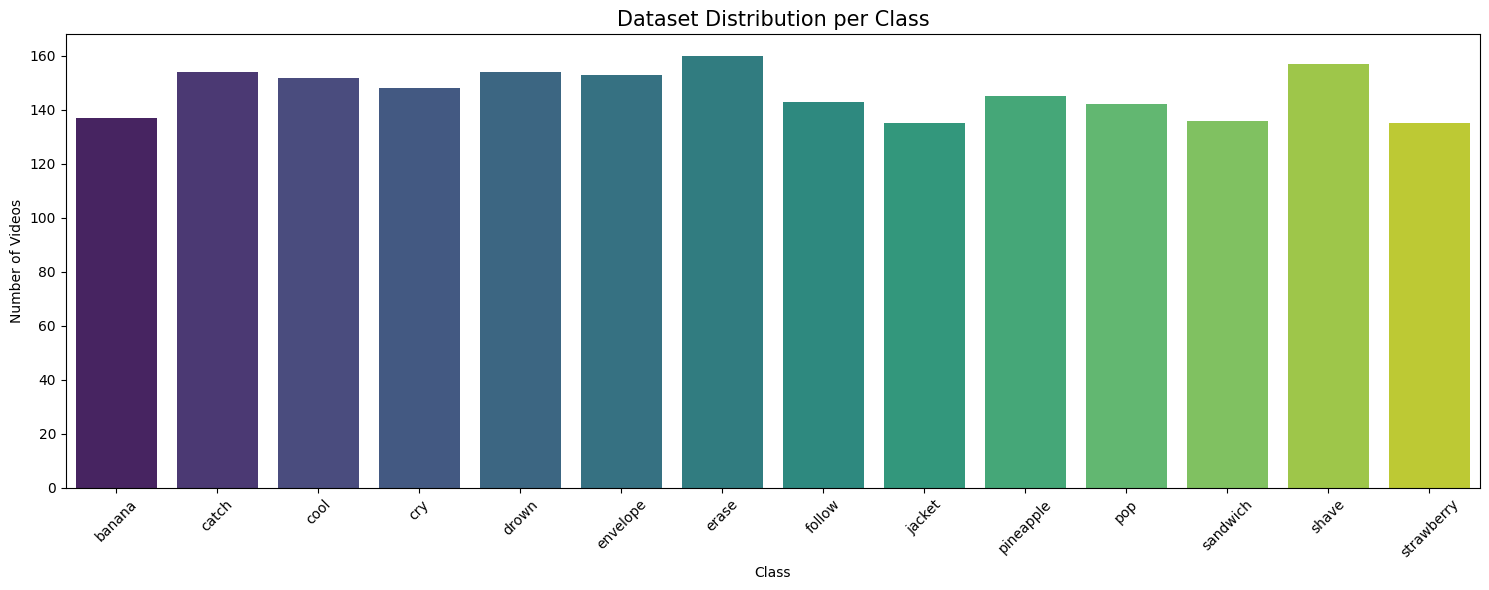


'label_map.json' saved successfully (Required for App).


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ==========================================
# 1. Configuration
# ==========================================
# Path to the shared folder where all 4 accounts saved the data
DATA_DIR = '/content/drive/MyDrive/weasel/try_20Word '

# Standard shape expected for the model
EXPECTED_SHAPE = (50, 198)

# ==========================================
# 2. Data Loading Function
# ==========================================
def load_and_analyze_data(data_dir):
    """
    Loads .npy files, verifies shapes, and generates statistics.
    Returns: X (features), y (labels), class_names (list)
    """
    if not os.path.exists(data_dir):
        print(f" Error: Directory '{data_dir}' not found.")
        return None, None, None

    # Get list of classes (folder names)
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort() # Sort alphabetically for consistency

    # Create a mapping: Class Name -> Index (0, 1, 2...)
    class_map = {label: i for i, label in enumerate(classes)}

    print(f" Found {len(classes)} classes: {classes}")
    print("-" * 50)

    X_list = []
    y_list = []
    stats = []

    # Iterate over each class folder
    for label in tqdm(classes, desc="Loading Classes"):
        class_path = os.path.join(data_dir, label)
        files = [f for f in os.listdir(class_path) if f.endswith('.npy')]

        valid_count = 0
        corrupt_count = 0

        for file_name in files:
            file_path = os.path.join(class_path, file_name)

            try:
                # Load the array
                data = np.load(file_path)

                # Check 1: Shape Validation
                if data.shape != EXPECTED_SHAPE:
                    # print(f" Warning: {file_name} has wrong shape {data.shape}, skipping.")
                    corrupt_count += 1
                    continue

                # Check 2: NaN/Inf Validation
                if np.isnan(data).any() or np.isinf(data).any():
                    # print(f"Warning: {file_name} contains NaN/Inf, skipping.")
                    corrupt_count += 1
                    continue

                # If valid, append to lists
                X_list.append(data)
                y_list.append(class_map[label])
                valid_count += 1

            except Exception as e:
                print(f" Error reading {file_name}: {e}")
                corrupt_count += 1

        # Record statistics for this class
        stats.append({
            'Class': label,
            'Valid_Samples': valid_count,
            'Corrupt_Samples': corrupt_count
        })

    # Convert lists to numpy arrays
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)

    return X, y, pd.DataFrame(stats), class_map

# ==========================================
# 3. Execution & Visualization
# ==========================================

print(" Starting Data Analysis...")
X, y, df_stats, label_map = load_and_analyze_data(DATA_DIR)

if X is not None:
    print("\n" + "="*50)
    print(" FINAL DATASET REPORT")
    print("="*50)
    print(f"Total Samples (X): {X.shape}")
    print(f"Total Labels (y):  {y.shape}")
    print(f"Feature Shape:     {X.shape[1:]} (Time Steps, Features)")
    print("-" * 50)

    # 1. Show Class Distribution Table
    print("\n Class Distribution:")
    print(df_stats.to_markdown(index=False))

    # 2. Check for Imbalance
    min_samples = df_stats['Valid_Samples'].min()
    max_samples = df_stats['Valid_Samples'].max()
    print(f"\n Balance Check:")
    print(f"   - Min Samples: {min_samples}")
    print(f"   - Max Samples: {max_samples}")
    if (max_samples - min_samples) > 50:
        print("    Note: Dataset is slightly imbalanced. Consider using 'class_weights' during training.")
    else:
        print("    Dataset is well-balanced.")

    # 3. Visualization (Bar Chart)
    plt.figure(figsize=(15, 6))
    sns.barplot(x='Class', y='Valid_Samples', data=df_stats, palette='viridis')
    plt.title('Dataset Distribution per Class', fontsize=15)
    plt.xticks(rotation=45)
    plt.ylabel('Number of Videos')
    plt.tight_layout()
    plt.show()

    # 4. Save Label Map for Deployment later
    import json
    with open('label_map.json', 'w') as f:
        # Convert int32 to int for JSON serialization
        json_map = {k: int(v) for k, v in label_map.items()}
        json.dump(json_map, f)
    print("\n'label_map.json' saved successfully (Required for App).")

else:
    print(" Failed to load data.")

>>> Loading data from Drive...
   - Class 'banana': Found 137 files.
   - Class 'catch': Found 154 files.
   - Class 'cool': Found 152 files.
   - Class 'cry': Found 148 files.
   - Class 'drown': Found 154 files.
   - Class 'envelope': Found 153 files.
   - Class 'erase': Found 160 files.
   - Class 'follow': Found 143 files.
   - Class 'jacket': Found 135 files.
   - Class 'pineapple': Found 145 files.
   - Class 'pop': Found 142 files.
   - Class 'sandwich': Found 136 files.
   - Class 'shave': Found 157 files.
   - Class 'strawberry': Found 135 files.

 Data Loaded Successfully!
Total Samples: 2051
Feature Vector Size: 792

>>> Splitting Data (80% Train, 20% Test)...
>>> Training XGBoost Model...
Training Complete.

>>> Evaluating...

 Test Accuracy: 79.56%

Classification Report:
              precision    recall  f1-score   support

      banana       0.92      0.85      0.88        27
       catch       0.73      0.87      0.79        31
        cool       0.67      0.73      0.

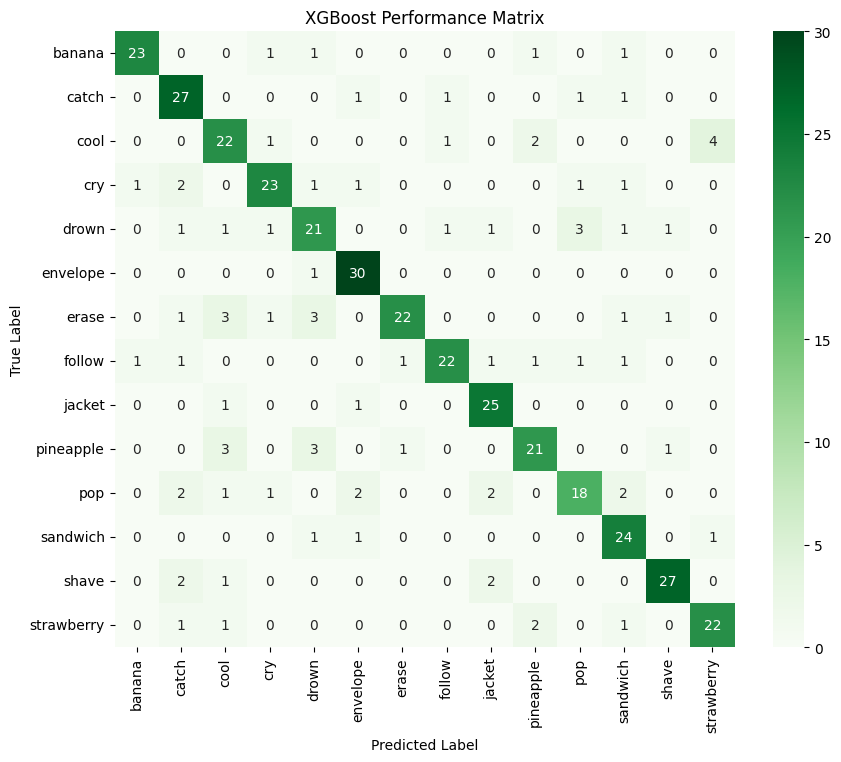

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier


# ==========================================
# 1. Configuration
# ==========================================
# Path where you saved the .npy files
CLASSES = ['banana', 'catch', 'cool', 'cry', 'drown', 'envelope', 'erase', 'follow', 'jacket', 'pineapple', 'pop', 'sandwich', 'shave', 'strawberry']

# ==========================================
# 2. Data Loading & Feature Engineering
# ==========================================
def load_and_engineer_data(data_dir, classes):
    X = []
    y = []

    print(">>> Loading data from Drive...")

    class_map = {label: i for i, label in enumerate(classes)}

    for label in classes:
        class_path = os.path.join(data_dir, label)
        if not os.path.exists(class_path):
            print(f" Warning: Folder not found for class '{label}'")
            continue

        files = os.listdir(class_path)
        print(f"   - Class '{label}': Found {len(files)} files.")

        for file_name in files:
            if file_name.endswith('.npy'):
                file_path = os.path.join(class_path, file_name)
                try:
                    # 1. Load Raw Data (50, 198)
                    raw_seq = np.load(file_path)

                    # 2. Feature Engineering (The Golden Recipe)
                    # Turn (50, 198) -> (1, 792) vector for XGBoost

                    # A. Statistical Features
                    mean_feat = np.mean(raw_seq, axis=0) # Shape (198,)
                    std_feat  = np.std(raw_seq, axis=0)  # Shape (198,)
                    max_feat  = np.max(raw_seq, axis=0)  # Shape (198,)

                    # B. Velocity Features (Motion)
                    velocity = np.diff(raw_seq, axis=0)  # Shape (49, 198)
                    mean_vel = np.mean(velocity, axis=0) # Shape (198,)

                    # Concatenate all features
                    final_vec = np.concatenate([mean_feat, std_feat, max_feat, mean_vel])

                    X.append(final_vec)
                    y.append(class_map[label])

                except Exception as e:
                    print(f"Error loading {file_name}: {e}")

    return np.array(X), np.array(y)

# Execute Loading
X_data, y_data = load_and_engineer_data(DATA_DIR, CLASSES)

# CHECK: Did we actually load data?
if len(X_data) == 0:
    print("\n CRITICAL ERROR: No data loaded.")
    print("This means the previous step didn't save the .npy files correctly.")
    print("Check your Drive folder '/content/drive/MyDrive/CV depi'")
else:
    print(f"\n Data Loaded Successfully!")
    print(f"Total Samples: {X_data.shape[0]}")
    print(f"Feature Vector Size: {X_data.shape[1]}")

    # ==========================================
    # 3. Splitting & Training
    # ==========================================
    print("\n>>> Splitting Data (80% Train, 20% Test)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
    )

    print(">>> Training XGBoost Model...")
    xgb_model = XGBClassifier(
        n_estimators=200,      # Number of trees
        learning_rate=0.05,    # Learning speed
        max_depth=6,           # Complexity of trees
        subsample=0.7,         # Prevent overfitting
        colsample_bytree=0.8,  # Prevent overfitting
        eval_metric='mlogloss',

        n_jobs=-1              # Use all CPU cores # 'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8
        ,min_child_weight=1


    )



    xgb_model.fit(X_train, y_train)
    print("Training Complete.")

    # ==========================================
    # 4. Evaluation
    # ==========================================
    print("\n>>> Evaluating...")
    y_pred = xgb_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n Test Accuracy: {acc*100:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=CLASSES))

    # Confusion Matrix Visualization
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('XGBoost Performance Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import numpy as np

# Assuming X_train, y_train are available and XGBClassifier is imported

# 1. Compute Sample Weights for Class Imbalance
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# 2. Define Parameter Grid for Tuning
param_dist = {
    'n_estimators': [200, 500, 800],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# 3. Base Estimator Configuration
# Note: num_class dynamically set based on y_train
xgb_base = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    tree_method='hist',
    device="cuda",
    random_state=42
)

# 4. Randomized Search Setup
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 5. Execute Search
print("Starting Hyperparameter Tuning...")
random_search.fit(X_train, y_train, sample_weight=sample_weights)

# 6. Report Best Parameters
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

# 7. Train Final Model using Best Parameters
print("\nTraining Final Model with Best Parameters...")
best_params = random_search.best_params_

# Initialize the final model using the best found settings
final_xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y_train)),
    tree_method='hist',
    device="cuda",
    random_state=42,
    n_jobs=-1,
    **best_params
)

# Train on the full training set (X_train)
final_xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

# Assign the final model to 'best_xgb' for downstream use (evaluation/saving)
best_xgb = final_xgb_model

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best Score: 0.731024795232409

Training Final Model with Best Parameters...


>>> Splitting Data...
Train: (1640, 50, 198), Val: (205, 50, 198), Test: (206, 50, 198)
Number of Classes: 14


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "ASL_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 198)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 50, 198)   │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 50, 198)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_1 (Any)         │ (None, 50)        │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    334,848 │ masking_1[0][0],  │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 50, 128)   │    164,352 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 128)   │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │ any_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 14)        │      3,598 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 571,150 (2.18 MB)

 Trainable params: 569,870 (2.17 MB)

 Non-trainable params: 1,280 (5.00 KB)


Starting Training...
Epoch 1/500
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0805 - loss: 3.8712
Epoch 1: val_accuracy improved from -inf to 0.12683, saving model to best_lstm_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.0814 - loss: 3.8593 - val_accuracy: 0.1268 - val_loss: 2.5610 - learning_rate: 0.0010
Epoch 2/500
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2025 - loss: 2.9501
Epoch 2: val_accuracy improved from 0.12683 to 0.24878, saving model to best_lstm_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.2023 - loss: 2.9475 - val_accuracy: 0.2488 - val_loss: 2.3806 - learning_rate: 0.0010
Epoch 3/500
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2198 - loss: 2.6775
Epoch 3: val_accuracy improved from 0.24878 to 0.25366, saving model to best_lstm_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2200 - loss: 2.6765 - val_accuracy: 0.2537 - val_loss: 2.2188 - learning_rate: 0.0010
Epoch 4/500
52/52 ━━━

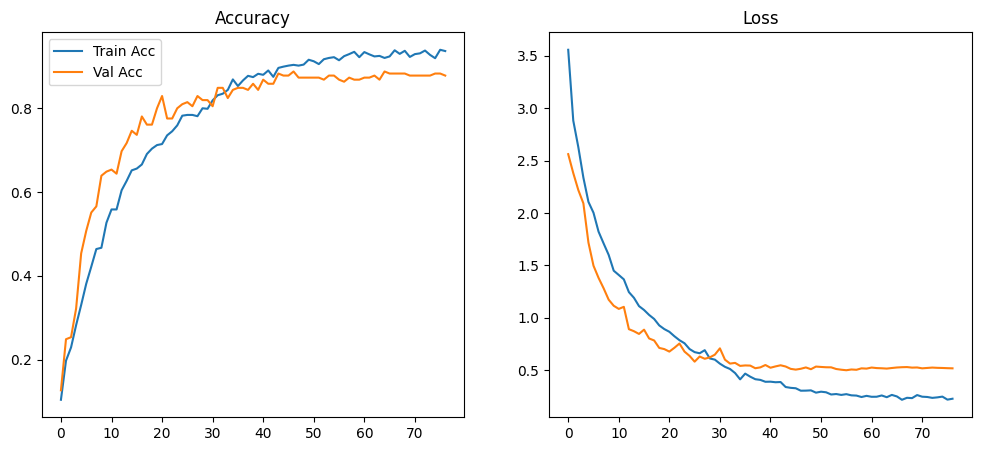

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


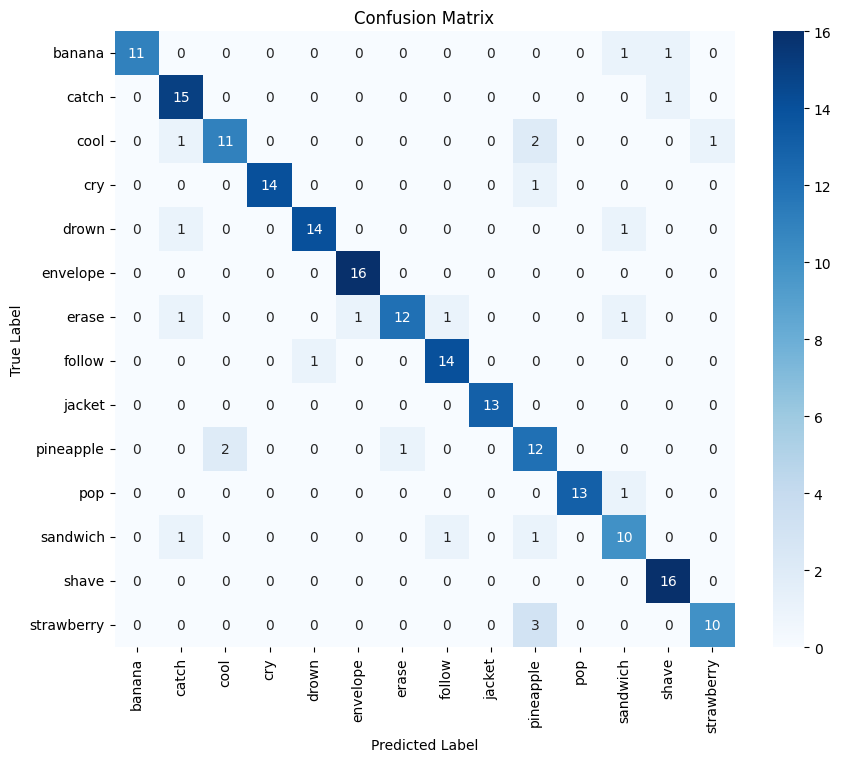

              precision    recall  f1-score   support

      banana       1.00      0.85      0.92        13
       catch       0.79      0.94      0.86        16
        cool       0.85      0.73      0.79        15
         cry       1.00      0.93      0.97        15
       drown       0.93      0.88      0.90        16
    envelope       0.94      1.00      0.97        16
       erase       0.92      0.75      0.83        16
      follow       0.88      0.93      0.90        15
      jacket       1.00      1.00      1.00        13
   pineapple       0.63      0.80      0.71        15
         pop       1.00      0.93      0.96        14
    sandwich       0.71      0.77      0.74        13
       shave       0.89      1.00      0.94        16
  strawberry       0.91      0.77      0.83        13

    accuracy                           0.88       206
   macro avg       0.89      0.88      0.88       206
weighted avg       0.89      0.88      0.88       206



In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# ==========================================
# 1. Prepare Data Splits
# ==========================================
print(">>> Splitting Data...")

# First split: Train (80%) + Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: Validation (10%) + Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Calculate number of classes dynamically
NUM_CLASSES = len(np.unique(y))
print(f"Number of Classes: {NUM_CLASSES}")

# ==========================================
# 2. Define Bi-LSTM Architecture (The Beast)
# ==========================================
def build_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Masking Layer (ignores zero-padded frames)
    x = layers.Masking(mask_value=0.0)(inputs)

    # 1st Bi-LSTM Block
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = layers.BatchNormalization()(x)

    # 2nd Bi-LSTM Block
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(x)
    x = layers.BatchNormalization()(x)

    # Hybrid Pooling Head (Avg + Max)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.Concatenate()([avg_pool, max_pool])

    # Dense Classification Block
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name="ASL_BiLSTM")

# Build & Compile
model = build_model((50, 198), NUM_CLASSES)

model.compile(
    optimizer=optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss="sparse_categorical_crossentropy", # Handles integers directly (no one-hot needed)
    metrics=["accuracy"]
)

model.summary()

# ==========================================
# 3. Start Training
# ==========================================
print("\nStarting Training...")

callbacks_list = [
    callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    callbacks.ModelCheckpoint('best_lstm_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=callbacks_list
)

# ==========================================
# 4. Evaluation & Visualization
# ==========================================
print("\n>>> Evaluating on Test Set...")
loss, acc = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {acc*100:.2f}%")

# Plot History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.show()

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get class names from label_map (reverse mapping)
# label_map is {name: id}, we need {id: name}
id_to_label = {v: k for k, v in label_map.items()}
class_names = [id_to_label[i] for i in range(NUM_CLASSES)]

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_test, y_pred, target_names=class_names))

In [15]:
import os
import joblib
import json
import tensorflow as tf
from google.colab import drive

# ==========================================
# 1. Configuration (المكان اللي هنحفظ فيه)
# ==========================================
# Assuming Drive is already mounted or will be mounted
SAVE_DIR = '/content/drive/MyDrive/weasel'

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

print(f"📂 Saving artifacts to: {SAVE_DIR}")

# ==========================================
# 2. Saving Label Map
# ==========================================
# (بافتراض أن label_map متغير موجود في الذاكرة)
if 'label_map' in globals():
    label_map_path = os.path.join(SAVE_DIR, 'label_map.json')
    try:
        with open(label_map_path, 'w') as f:
            clean_map = {k: int(v) for k, v in label_map.items()}
            json.dump(clean_map, f)
        print("✅ Label Map saved successfully.")
    except Exception as e:
        print(f"⚠️ Warning: Could not save label map. {e}")
else:
    print("⚠️ Warning: label_map variable not found in memory.")

# ==========================================
# 3. Saving XGBoost Model
# ==========================================
# (بافترض أن xgb_model هو المتغير اللي فيه الموديل)
if 'xgb_model' in globals():
    xgb_path = os.path.join(SAVE_DIR, 'xgboost_asl_2.pkl')
    joblib.dump(xgb_model, xgb_path)
    print(f" XGBoost Model saved (via joblib): {xgb_path}")
else:
    print(" XGBoost model not found in memory (Skipped).")

# ==========================================
# 4. Saving Deep Learning Model (Keras & TFLite)
# ==========================================
# (بافترض أن model هو المتغير اللي فيه الموديل)
if 'model' in globals():

    # A. Standard Keras (Backup)
    keras_path = os.path.join(SAVE_DIR, 'bilstm_model_2.keras')
    model.save(keras_path)
    print(f" Keras Model saved (Training Backup): {keras_path}")

    # B. TFLite (The FASTEST for Real-time)
    print(" Converting to TFLite (Optimized for Speed)...")
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Optimization: ضغط الموديل وتسريعه (Quantization)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Required for complex ops like LSTM on TFLite runtime
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    # Required for some Colab environments/TF versions
    try:
        converter._experimental_lower_tensor_list_ops = False
    except AttributeError:
        pass

    tflite_model = converter.convert()

    tflite_path = os.path.join(SAVE_DIR, 'bilstm_model_optimized.tflite')
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    print(f" TFLite Model saved (FASTEST for Inference): {tflite_path}")

else:
    print(" Deep Learning model not found in memory.")

print("\n All Done! Download the folder from Drive.")

📂 Saving artifacts to: /content/drive/MyDrive/weasel
✅ Label Map saved successfully.
 XGBoost Model saved (via joblib): /content/drive/MyDrive/weasel/xgboost_asl_2.pkl
 Keras Model saved (Training Backup): /content/drive/MyDrive/weasel/bilstm_model_2.keras
 Converting to TFLite (Optimized for Speed)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Saved artifact at '/tmp/tmpm_o3w208'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 198), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  140026279164816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140026471926096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140026279164624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140026279161360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140026279163280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140026279160784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140026279161552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140026279165392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140026279161744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140026279160592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14002627916347

ConverterError: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_2_1/backward_lstm_2_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_2_1/backward_lstm_2_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x198xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<167936xf32>, tensor<?xi32>) -> (tensor<?x50x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_2_1/backward_lstm_2_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_2_1/forward_lstm_2_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_2_1/forward_lstm_2_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x198xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<167936xf32>, tensor<?xi32>) -> (tensor<?x50x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_2_1/forward_lstm_2_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_3_1/backward_lstm_3_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_3_1/backward_lstm_3_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x50x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_3_1/backward_lstm_3_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_3_1/forward_lstm_3_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_3_1/forward_lstm_3_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x50x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "ASL_BiLSTM_1/bidirectional_3_1/forward_lstm_3_1/CudnnRNNV3@__inference_function_130642"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_130781"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall_1"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops in the model are custom ops, See instructions to implement custom ops: https://www.tensorflow.org/lite/guide/ops_custom 
Custom ops: CudnnRNNV3
Details:
	tf.CudnnRNNV3(tensor<?x50x198xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<167936xf32>, tensor<?xi32>) -> (tensor<?x50x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}
	tf.CudnnRNNV3(tensor<?x50x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x50x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}

<unknown>:0: note: see current operation: 
"func.func"() <{arg_attrs = [{tf_saved_model.index_path = ["keras_tensor_15"]}], function_type = (tensor<?x50x198xf32>) -> tensor<?x14xf32>, res_attrs = [{tf_saved_model.index_path = ["output_0"]}], sym_name = "main"}> ({
^bb0(%arg0: tensor<?x50x198xf32>):
  "tfl.call_once"() <{session_init_function = "NoOp"}> : () -> ()
  %0 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<82432xf32>}> : () -> tensor<82432xf32>
  %1 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<82432xf32>}> : () -> tensor<82432xf32>
  %2 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<167936xf32>}> : () -> tensor<167936xf32>
  %3 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<167936xf32>}> : () -> tensor<167936xf32>
  %4 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<256xf32>}> : () -> tensor<256xf32>
  %5 = "arith.constant"() <{value = dense<-1> : tensor<1xi32>}> : () -> tensor<1xi32>
  %6 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<f32>}> : () -> tensor<f32>
  %7 = "arith.constant"() <{value = dense<1> : tensor<1xi32>}> : () -> tensor<1xi32>
  %8 = "arith.constant"() <{value = dense<1> : tensor<i32>}> : () -> tensor<i32>
  %9 = "arith.constant"() <{value = dense<[0, 1]> : tensor<2xi64>}> : () -> tensor<2xi64>
  %10 = "arith.constant"() <{value = dense<0> : tensor<1xi32>}> : () -> tensor<1xi32>
  %11 = "arith.constant"() <{value = dense<-1> : tensor<i32>}> : () -> tensor<i32>
  %12 = "arith.constant"() <{value = dense<128> : tensor<i32>}> : () -> tensor<i32>
  %13 = "arith.constant"() <{value = dense<64> : tensor<i32>}> : () -> tensor<i32>
  %14 = "arith.constant"() <{value = dense<2> : tensor<i32>}> : () -> tensor<i32>
  %15 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<256xf32>}> : () -> tensor<256xf32>
  %16 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<256xf32>}> : () -> tensor<256xf32>
  %17 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<128xf32>}> : () -> tensor<128xf32>
  %18 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<128xf32>}> : () -> tensor<128xf32>
  %19 = "arith.constant"() <{value = dense<[3.64171672, -2.50320101, 4.221960e+00, 1.97784638, -5.40523624, -4.29176283, -1.83184302, -0.922255158, -0.911640763, 5.70713329, -4.53752804, -0.767518579, 3.145370e+00, 3.63943338]> : tensor<14xf32>}> : () -> tensor<14xf32>
  %20 = "tfl.pseudo_qconst"() <{qtype = tensor<14x256x!quant.uniform<i8<-127:127>:f32:0, {0.034651786323607436,0.034563901856189641,0.036658583663579984,0.034868428087609961,0.035864728642260937,0.035014182563841811,0.044970516144760012,0.030215126322949027,0.033828239741287833,0.029476764633899599,0.031487891054528906,0.028654109774612066,0.033395065097358283,0.030127390163151298}>>, value = dense_resource<__elided__> : tensor<14x256xi8>}> : () -> tensor<14x256x!quant.uniform<i8<-127:127>:f32:0, {0.034651786323607436,0.034563901856189641,0.036658583663579984,0.034868428087609961,0.035864728642260937,0.035014182563841811,0.044970516144760012,0.030215126322949027,0.033828239741287833,0.029476764633899599,0.031487891054528906,0.028654109774612066,0.033395065097358283,0.030127390163151298}>>
  %21 = "tfl.pseudo_qconst"() <{qtype = tensor<256x256x!quant.uniform<i8<-127:127>:f32:0, {0.0014586690373308076,0.0015086884808352614,0.001468901324459887,0.0013549657553199707,0.0013209600148238534,0.0014856239472787211,0.0014990766452053401,0.0012563370813534955,0.0010123959207159327,0.0012022361276656623,0.0012933317366547472,0.0013256674911093524,0.0014107813985328975,0.001380091577064334,9.9569805494443631E-4,0.0014980851899920487,0.0013467676526918186,0.0012667424331499835,0.0013756729721084355,0.0015576378567012277,0.0018733245885278295,0.0015523867813620981,0.0013671066817336195,0.0012660167348666454,0.0013822662079428125,0.0012218271653483233,0.0011213833656836683,0.0012661683277820977,0.0012742449918131189,0.0010796283173748827,0.0016977408035533635,0.0012458546424475242,0.001462227129560756,0.0010206630145470927,0.0012023511130040087,0.0011402153828012661,0.0013608156930743241,0.001224305803381552,0.001467863757779279,0.0013642585653019703,0.0015281644158475982,0.0010450916496787485,0.001526276074995206,0.0017246911375541386,0.0013093605754882331,0.0011479353576194582,0.0015375148358307486,0.0012103193622874462,0.0014092538535125613,0.0015031437235554373,0.0013666714974275725,0.0017727218040331143,0.0013502917186481746,0.001350536473154083,0.0012832815487553754,0.0012056709039868331,0.0013043096685034083,0.0013019096428953756,0.0012388442914316974,0.0012594196270769974,0.0011034013014140092,0.0011821777567150085,0.0014811381110994835,0.0011970464169509768,0.0011259232919047198,0.0012618560255981805,0.0011946357141329547,0.001170123655965009,0.001124533611958421,0.001407135189987543,0.0013273860525897169,0.0010588035339445579,0.0010924145696670051,0.0014054927769608385,0.0014568789033439216,0.0013119856438298864,0.001405570802726145,0.0010158288197254571,0.0012838738405798365,0.0010155641187833051,0.0012071214792296642,0.0014891158642731314,0.0013007726960294829,0.0018376948561255387,0.001486901927182055,0.001328018706614577,0.0014300720663521233,0.0013084776523545033,0.0014201825059305027,0.0014011398779125665,0.0011514251626382663,0.001290893108825984,0.0014161973253009827,0.0013916891390883077,0.0011786635466447966,0.0015238615002219132,0.0015080987703143143,0.0014168934559258889,0.0012572218817988718,0.0011756444775213406,0.0014814175958708516,0.0012600286973742988,0.0015685774209931141,0.0019959596198374833,0.001006850694108197,0.001399329328161525,0.0013620526067853913,0.0015523678909136554,0.0011868571906577883,0.0011862686534566203,0.0017144265841311356,0.0010912549777293769,0.001325506042307756,0.0014295466537550679,0.0012315099868248766,0.0015160315853404247,0.0012216451834505936,0.0011533372045501949,0.0015115979618913545,0.0011480694680702029,0.0011943302989944698,0.0011300889291162566,0.0010564617049975658,0.0010792384232123067,0.0014636572890394316,9.4382112889777956E-4,0.0011294582697350208,0.0013092600219831692,0.0015490931554103461,0.0013830394256772018,0.0014131952693143229,0.0013568797918755238,9.5469363796429375E-4,0.0011289265212111586,0.0014011849333920817,0.0012851039490361853,0.0011662183784124419,0.0010752026725003099,0.0015264561795812891,0.0010575646255898664,0.0014284898446300838,0.0010446320603212972,0.0010809067666061282,0.0011964046110318402,0.0013470954782380832,0.0013562267220865085,0.0015497649983158262,0.0012007942349891963,0.0010440308512665154,0.0011891890463866586,0.0014046493947036623,0.0010270267490326888,0.0012281702494058083,0.0013406647471931037,0.001001261702672703,0.0015363528972535622,0.0012902270151874211,0.0012887597788037277,0.0014494903913633091,0.0013286860909048966,0.0014272713520395474,0.0013560389909218614,0.0011029352587977731,0.0012219588118275321,0.0012814326314475593,0.0013642115151788305,0.0014746453114381926,0.0012816525115741518,0.0014571833798265833,0.0012154607322272352,0.0013941391481189277,9.4042296015371489E-4,0.0013205812671991783,0.00122094107425119,0.0015073525389348427,0.0012832714582052757,0.0014945438762349406,0.0013700261360078347,0.001314444687422805,9.9197569794542213E-4,0.0013334504731996792,0.0013363147814442792,0.0011360141940004243,0.0011127149964880755,0.0011252171880616916,0.0012947489896158533,0.0014841499056403092,0.001305271556058268,0.0016378831910336112,0.001401004359478087,0.0010138484906023881,0.001190962871228616,0.0013880548984046997,0.0015154605306039646,0.0013058247763340868,0.0011144639469507173,0.0013987426682720034,0.0013742412873140471,0.0015269375926866306,0.0012782909504071933,0.0011754014829951009,0.001252943488556569,0.0010618446614798598,0.001523565002313749,0.0014539549904545462,0.0012913131573068814,0.0014211374708986658,0.0013905241498796959,0.0012988742646269911,0.0014112091909243365,0.0013905032647876289,0.0010835313656198697,9.5785374012519056E-4,0.0014642101573193167,0.0012804572507152407,0.0011572489353615467,0.001423529517932201,0.0015278208678162943,0.0012931732211525985,0.0011614503588263444,0.0011698938026202944,0.0014560097080516064,0.0013893003773501539,0.0012055811450237363,0.0012450218200683594,0.0014096178173080205,0.0014554771382038988,0.0010420443035486177,0.0013683074571954922,0.0011695916727771909,0.0013640667275180967,0.0013897530441209086,0.0011298621264029677,0.0012384208403234407,0.0011386630807335922,0.0011380714929009985,9.8705514678804887E-4,0.0012838199852019782,0.0010722995273710237,0.0015034960714850839,0.001361135892042025,0.001397965813246299,0.00141588897686305,0.0013447179803698082,0.0015690628233857042,0.0014545749726257926,0.0012666248665081235,0.0015568755508407832,0.0013546507189592977,0.0011159961852501695,0.0010650274087124923,0.0010453491933702483,0.0013603685409065308,0.001389313870527613,0.0012584077560995508,0.001333496115339084}>>, value = dense_resource<__elided__> : tensor<256x256xi8>}> : () -> tensor<256x256x!quant.uniform<i8<-127:127>:f32:0, {0.0014586690373308076,0.0015086884808352614,0.001468901324459887,0.0013549657553199707,0.0013209600148238534,0.0014856239472787211,0.0014990766452053401,0.0012563370813534955,0.0010123959207159327,0.0012022361276656623,0.0012933317366547472,0.0013256674911093524,0.0014107813985328975,0.001380091577064334,9.9569805494443631E-4,0.0014980851899920487,0.0013467676526918186,0.0012667424331499835,0.0013756729721084355,0.0015576378567012277,0.0018733245885278295,0.0015523867813620981,0.0013671066817336195,0.0012660167348666454,0.0013822662079428125,0.0012218271653483233,0.0011213833656836683,0.0012661683277820977,0.0012742449918131189,0.0010796283173748827,0.0016977408035533635,0.0012458546424475242,0.001462227129560756,0.0010206630145470927,0.0012023511130040087,0.0011402153828012661,0.0013608156930743241,0.001224305803381552,0.001467863757779279,0.0013642585653019703,0.0015281644158475982,0.0010450916496787485,0.001526276074995206,0.0017246911375541386,0.0013093605754882331,0.0011479353576194582,0.0015375148358307486,0.0012103193622874462,0.0014092538535125613,0.0015031437235554373,0.0013666714974275725,0.0017727218040331143,0.0013502917186481746,0.001350536473154083,0.0012832815487553754,0.0012056709039868331,0.0013043096685034083,0.0013019096428953756,0.0012388442914316974,0.0012594196270769974,0.0011034013014140092,0.0011821777567150085,0.0014811381110994835,0.0011970464169509768,0.0011259232919047198,0.0012618560255981805,0.0011946357141329547,0.001170123655965009,0.001124533611958421,0.001407135189987543,0.0013273860525897169,0.0010588035339445579,0.0010924145696670051,0.0014054927769608385,0.0014568789033439216,0.0013119856438298864,0.001405570802726145,0.0010158288197254571,0.0012838738405798365,0.0010155641187833051,0.0012071214792296642,0.0014891158642731314,0.0013007726960294829,0.0018376948561255387,0.001486901927182055,0.001328018706614577,0.0014300720663521233,0.0013084776523545033,0.0014201825059305027,0.0014011398779125665,0.0011514251626382663,0.001290893108825984,0.0014161973253009827,0.0013916891390883077,0.0011786635466447966,0.0015238615002219132,0.0015080987703143143,0.0014168934559258889,0.0012572218817988718,0.0011756444775213406,0.0014814175958708516,0.0012600286973742988,0.0015685774209931141,0.0019959596198374833,0.001006850694108197,0.001399329328161525,0.0013620526067853913,0.0015523678909136554,0.0011868571906577883,0.0011862686534566203,0.0017144265841311356,0.0010912549777293769,0.001325506042307756,0.0014295466537550679,0.0012315099868248766,0.0015160315853404247,0.0012216451834505936,0.0011533372045501949,0.0015115979618913545,0.0011480694680702029,0.0011943302989944698,0.0011300889291162566,0.0010564617049975658,0.0010792384232123067,0.0014636572890394316,9.4382112889777956E-4,0.0011294582697350208,0.0013092600219831692,0.0015490931554103461,0.0013830394256772018,0.0014131952693143229,0.0013568797918755238,9.5469363796429375E-4,0.0011289265212111586,0.0014011849333920817,0.0012851039490361853,0.0011662183784124419,0.0010752026725003099,0.0015264561795812891,0.0010575646255898664,0.0014284898446300838,0.0010446320603212972,0.0010809067666061282,0.0011964046110318402,0.0013470954782380832,0.0013562267220865085,0.0015497649983158262,0.0012007942349891963,0.0010440308512665154,0.0011891890463866586,0.0014046493947036623,0.0010270267490326888,0.0012281702494058083,0.0013406647471931037,0.001001261702672703,0.0015363528972535622,0.0012902270151874211,0.0012887597788037277,0.0014494903913633091,0.0013286860909048966,0.0014272713520395474,0.0013560389909218614,0.0011029352587977731,0.0012219588118275321,0.0012814326314475593,0.0013642115151788305,0.0014746453114381926,0.0012816525115741518,0.0014571833798265833,0.0012154607322272352,0.0013941391481189277,9.4042296015371489E-4,0.0013205812671991783,0.00122094107425119,0.0015073525389348427,0.0012832714582052757,0.0014945438762349406,0.0013700261360078347,0.001314444687422805,9.9197569794542213E-4,0.0013334504731996792,0.0013363147814442792,0.0011360141940004243,0.0011127149964880755,0.0011252171880616916,0.0012947489896158533,0.0014841499056403092,0.001305271556058268,0.0016378831910336112,0.001401004359478087,0.0010138484906023881,0.001190962871228616,0.0013880548984046997,0.0015154605306039646,0.0013058247763340868,0.0011144639469507173,0.0013987426682720034,0.0013742412873140471,0.0015269375926866306,0.0012782909504071933,0.0011754014829951009,0.001252943488556569,0.0010618446614798598,0.001523565002313749,0.0014539549904545462,0.0012913131573068814,0.0014211374708986658,0.0013905241498796959,0.0012988742646269911,0.0014112091909243365,0.0013905032647876289,0.0010835313656198697,9.5785374012519056E-4,0.0014642101573193167,0.0012804572507152407,0.0011572489353615467,0.001423529517932201,0.0015278208678162943,0.0012931732211525985,0.0011614503588263444,0.0011698938026202944,0.0014560097080516064,0.0013893003773501539,0.0012055811450237363,0.0012450218200683594,0.0014096178173080205,0.0014554771382038988,0.0010420443035486177,0.0013683074571954922,0.0011695916727771909,0.0013640667275180967,0.0013897530441209086,0.0011298621264029677,0.0012384208403234407,0.0011386630807335922,0.0011380714929009985,9.8705514678804887E-4,0.0012838199852019782,0.0010722995273710237,0.0015034960714850839,0.001361135892042025,0.001397965813246299,0.00141588897686305,0.0013447179803698082,0.0015690628233857042,0.0014545749726257926,0.0012666248665081235,0.0015568755508407832,0.0013546507189592977,0.0011159961852501695,0.0010650274087124923,0.0010453491933702483,0.0013603685409065308,0.001389313870527613,0.0012584077560995508,0.001333496115339084}>>
  %22 = "tfl.var_handle"() <{container = "", shared_name = "seed_generator_9/seed_generator_state_1"}> : () -> tensor<!tf_type.resource<tensor<2xi64>>>
  %23 = "tfl.var_handle"() <{container = "", shared_name = "seed_generator_8/seed_generator_state_1"}> : () -> tensor<!tf_type.resource<tensor<2xi64>>>
  %24 = "tfl.var_handle"() <{container = "", shared_name = "seed_generator_12/seed_generator_state_1"}> : () -> tensor<!tf_type.resource<tensor<2xi64>>>
  %25 = "tfl.var_handle"() <{container = "", shared_name = "seed_generator_11/seed_generator_state_1"}> : () -> tensor<!tf_type.resource<tensor<2xi64>>>
  %26 = "tfl.read_variable"(%22) : (tensor<!tf_type.resource<tensor<2xi64>>>) -> tensor<2xi64>
  %27 = "tfl.add"(%26, %9) <{fused_activation_function = "NONE"}> : (tensor<2xi64>, tensor<2xi64>) -> tensor<2xi64>
  "tfl.assign_variable"(%22, %27) : (tensor<!tf_type.resource<tensor<2xi64>>>, tensor<2xi64>) -> ()
  %28 = "tfl.read_variable"(%23) : (tensor<!tf_type.resource<tensor<2xi64>>>) -> tensor<2xi64>
  %29 = "tfl.add"(%28, %9) <{fused_activation_function = "NONE"}> : (tensor<2xi64>, tensor<2xi64>) -> tensor<2xi64>
  "tfl.assign_variable"(%23, %29) : (tensor<!tf_type.resource<tensor<2xi64>>>, tensor<2xi64>) -> ()
  %30 = "tfl.read_variable"(%24) : (tensor<!tf_type.resource<tensor<2xi64>>>) -> tensor<2xi64>
  %31 = "tfl.add"(%30, %9) <{fused_activation_function = "NONE"}> : (tensor<2xi64>, tensor<2xi64>) -> tensor<2xi64>
  "tfl.assign_variable"(%24, %31) : (tensor<!tf_type.resource<tensor<2xi64>>>, tensor<2xi64>) -> ()
  %32 = "tfl.read_variable"(%25) : (tensor<!tf_type.resource<tensor<2xi64>>>) -> tensor<2xi64>
  %33 = "tfl.add"(%32, %9) <{fused_activation_function = "NONE"}> : (tensor<2xi64>, tensor<2xi64>) -> tensor<2xi64>
  "tfl.assign_variable"(%25, %33) : (tensor<!tf_type.resource<tensor<2xi64>>>, tensor<2xi64>) -> ()
  %34 = "tfl.not_equal"(%arg0, %6) : (tensor<?x50x198xf32>, tensor<f32>) -> tensor<?x50x198xi1>
  %35 = "tfl.reduce_any"(%34, %5) <{keep_dims = false}> : (tensor<?x50x198xi1>, tensor<1xi32>) -> tensor<?x50xi1>
  %36 = "tfl.cast"(%35) : (tensor<?x50xi1>) -> tensor<?x50xi32>
  %37 = "tfl.sum"(%36, %8) <{keep_dims = false}> : (tensor<?x50xi32>, tensor<i32>) -> tensor<?xi32>
  %38 = "tfl.cast"(%35) : (tensor<?x50xi1>) -> tensor<?x50xf32>
  %39 = "tfl.expand_dims"(%38, %14) : (tensor<?x50xf32>, tensor<i32>) -> tensor<?x50x1xf32>
  %40 = "tfl.sum"(%39, %8) <{keep_dims = false}> : (tensor<?x50x1xf32>, tensor<i32>) -> tensor<?x1xf32>
  %41 = "tfl.reduce_any"(%34, %11) <{keep_dims = true}> : (tensor<?x50x198xi1>, tensor<i32>) -> tensor<?x50x1xi1>
  %42 = "tfl.cast"(%41) : (tensor<?x50x1xi1>) -> tensor<?x50x1xf32>
  %43 = "tfl.mul"(%arg0, %42) <{fused_activation_function = "NONE"}> : (tensor<?x50x198xf32>, tensor<?x50x1xf32>) -> tensor<?x50x198xf32>
  %44 = "tfl.reverse_sequence"(%43, %37) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x50x198xf32>, tensor<?xi32>) -> tensor<?x50x198xf32>
  %45 = "tfl.shape"(%43) : (tensor<?x50x198xf32>) -> tensor<3xi32>
  %46 = "tfl.strided_slice"(%45, %10, %7, %7) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %47 = "tfl.pack"(%46, %12) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %48 = "tfl.fill"(%47, %6) : (tensor<2xi32>, tensor<f32>) -> tensor<?x128xf32>
  %49 = "tfl.expand_dims"(%48, %8) : (tensor<?x128xf32>, tensor<i32>) -> tensor<?x1x128xf32>
  %50:5 = "tfl.custom_tf"(%44, %49, %49, %3, %37) ({
  ^bb0(%arg16: tensor<?x50x198xf32>, %arg17: tensor<?x1x128xf32>, %arg18: tensor<?x1x128xf32>, %arg19: tensor<167936xf32>, %arg20: tensor<?xi32>):
    %83:5 = "tf.CudnnRNNV3"(%arg16, %arg17, %arg18, %arg19, %arg20) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x198xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<167936xf32>, tensor<?xi32>) -> (tensor<?x50x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%83#0, %83#1, %83#2, %83#3, %83#4) : (tensor<?x50x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x198xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<167936xf32>, tensor<?xi32>) -> (tensor<?x50x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
  %51 = "tfl.reverse_sequence"(%50#0, %37) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x50x128xf32>, tensor<?xi32>) -> tensor<?x50x128xf32>
  %52 = "tfl.reverse_v2"(%51, %7) : (tensor<?x50x128xf32>, tensor<1xi32>) -> tensor<?x50x128xf32>
  %53 = "tfl.reverse_v2"(%52, %7) : (tensor<?x50x128xf32>, tensor<1xi32>) -> tensor<?x50x128xf32>
  %54:5 = "tfl.custom_tf"(%43, %49, %49, %2, %37) ({
  ^bb0(%arg11: tensor<?x50x198xf32>, %arg12: tensor<?x1x128xf32>, %arg13: tensor<?x1x128xf32>, %arg14: tensor<167936xf32>, %arg15: tensor<?xi32>):
    %82:5 = "tf.CudnnRNNV3"(%arg11, %arg12, %arg13, %arg14, %arg15) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x198xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<167936xf32>, tensor<?xi32>) -> (tensor<?x50x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%82#0, %82#1, %82#2, %82#3, %82#4) : (tensor<?x50x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x198xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<167936xf32>, tensor<?xi32>) -> (tensor<?x50x128xf32>, tensor<?x1x128xf32>, tensor<?x1x128xf32>, tensor<*xf32>, tensor<*xi8>)
  %55 = "tfl.concatenation"(%54#0, %53) <{axis = -1 : i32, fused_activation_function = "NONE"}> : (tensor<?x50x128xf32>, tensor<?x50x128xf32>) -> tensor<?x50x256xf32>
  %56 = "tfl.mul"(%55, %15) <{fused_activation_function = "NONE"}> : (tensor<?x50x256xf32>, tensor<256xf32>) -> tensor<?x50x256xf32>
  %57 = "tfl.add"(%56, %16) <{fused_activation_function = "NONE"}> : (tensor<?x50x256xf32>, tensor<256xf32>) -> tensor<?x50x256xf32>
  %58 = "tfl.reverse_sequence"(%57, %37) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x50x256xf32>, tensor<?xi32>) -> tensor<?x50x256xf32>
  %59 = "tfl.shape"(%57) : (tensor<?x50x256xf32>) -> tensor<3xi32>
  %60 = "tfl.strided_slice"(%59, %10, %7, %7) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %61 = "tfl.pack"(%60, %13) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %62 = "tfl.fill"(%61, %6) : (tensor<2xi32>, tensor<f32>) -> tensor<?x64xf32>
  %63 = "tfl.expand_dims"(%62, %8) : (tensor<?x64xf32>, tensor<i32>) -> tensor<?x1x64xf32>
  %64:5 = "tfl.custom_tf"(%58, %63, %63, %1, %37) ({
  ^bb0(%arg6: tensor<?x50x256xf32>, %arg7: tensor<?x1x64xf32>, %arg8: tensor<?x1x64xf32>, %arg9: tensor<82432xf32>, %arg10: tensor<?xi32>):
    %81:5 = "tf.CudnnRNNV3"(%arg6, %arg7, %arg8, %arg9, %arg10) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x50x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%81#0, %81#1, %81#2, %81#3, %81#4) : (tensor<?x50x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x50x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %65 = "tfl.reverse_sequence"(%64#0, %37) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x50x64xf32>, tensor<?xi32>) -> tensor<?x50x64xf32>
  %66 = "tfl.reverse_v2"(%65, %7) : (tensor<?x50x64xf32>, tensor<1xi32>) -> tensor<?x50x64xf32>
  %67 = "tfl.reverse_v2"(%66, %7) : (tensor<?x50x64xf32>, tensor<1xi32>) -> tensor<?x50x64xf32>
  %68:5 = "tfl.custom_tf"(%57, %63, %63, %0, %37) ({
  ^bb0(%arg1: tensor<?x50x256xf32>, %arg2: tensor<?x1x64xf32>, %arg3: tensor<?x1x64xf32>, %arg4: tensor<82432xf32>, %arg5: tensor<?xi32>):
    %80:5 = "tf.CudnnRNNV3"(%arg1, %arg2, %arg3, %arg4, %arg5) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x50x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%80#0, %80#1, %80#2, %80#3, %80#4) : (tensor<?x50x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x50x256xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<82432xf32>, tensor<?xi32>) -> (tensor<?x50x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %69 = "tfl.concatenation"(%68#0, %67) <{axis = -1 : i32, fused_activation_function = "NONE"}> : (tensor<?x50x64xf32>, tensor<?x50x64xf32>) -> tensor<?x50x128xf32>
  %70 = "tfl.mul"(%69, %17) <{fused_activation_function = "NONE"}> : (tensor<?x50x128xf32>, tensor<128xf32>) -> tensor<?x50x128xf32>
  %71 = "tfl.add"(%70, %18) <{fused_activation_function = "NONE"}> : (tensor<?x50x128xf32>, tensor<128xf32>) -> tensor<?x50x128xf32>
  %72 = "tfl.mul"(%71, %39) <{fused_activation_function = "NONE"}> : (tensor<?x50x128xf32>, tensor<?x50x1xf32>) -> tensor<?x50x128xf32>
  %73 = "tfl.sum"(%72, %8) <{keep_dims = false}> : (tensor<?x50x128xf32>, tensor<i32>) -> tensor<?x128xf32>
  %74 = "tfl.div"(%73, %40) <{fused_activation_function = "NONE"}> : (tensor<?x128xf32>, tensor<?x1xf32>) -> tensor<?x128xf32>
  %75 = "tfl.reduce_max"(%71, %8) <{keep_dims = false}> : (tensor<?x50x128xf32>, tensor<i32>) -> tensor<?x128xf32>
  %76 = "tfl.concatenation"(%74, %75) <{axis = -1 : i32, fused_activation_function = "NONE"}> : (tensor<?x128xf32>, tensor<?x128xf32>) -> tensor<?x256xf32>
  %77 = "tfl.fully_connected"(%76, %21, %4) <{asymmetric_quantize_inputs = true, fused_activation_function = "RELU", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x256xf32>, tensor<256x256x!quant.uniform<i8<-127:127>:f32:0, {0.0014586690373308076,0.0015086884808352614,0.001468901324459887,0.0013549657553199707,0.0013209600148238534,0.0014856239472787211,0.0014990766452053401,0.0012563370813534955,0.0010123959207159327,0.0012022361276656623,0.0012933317366547472,0.0013256674911093524,0.0014107813985328975,0.001380091577064334,9.9569805494443631E-4,0.0014980851899920487,0.0013467676526918186,0.0012667424331499835,0.0013756729721084355,0.0015576378567012277,0.0018733245885278295,0.0015523867813620981,0.0013671066817336195,0.0012660167348666454,0.0013822662079428125,0.0012218271653483233,0.0011213833656836683,0.0012661683277820977,0.0012742449918131189,0.0010796283173748827,0.0016977408035533635,0.0012458546424475242,0.001462227129560756,0.0010206630145470927,0.0012023511130040087,0.0011402153828012661,0.0013608156930743241,0.001224305803381552,0.001467863757779279,0.0013642585653019703,0.0015281644158475982,0.0010450916496787485,0.001526276074995206,0.0017246911375541386,0.0013093605754882331,0.0011479353576194582,0.0015375148358307486,0.0012103193622874462,0.0014092538535125613,0.0015031437235554373,0.0013666714974275725,0.0017727218040331143,0.0013502917186481746,0.001350536473154083,0.0012832815487553754,0.0012056709039868331,0.0013043096685034083,0.0013019096428953756,0.0012388442914316974,0.0012594196270769974,0.0011034013014140092,0.0011821777567150085,0.0014811381110994835,0.0011970464169509768,0.0011259232919047198,0.0012618560255981805,0.0011946357141329547,0.001170123655965009,0.001124533611958421,0.001407135189987543,0.0013273860525897169,0.0010588035339445579,0.0010924145696670051,0.0014054927769608385,0.0014568789033439216,0.0013119856438298864,0.001405570802726145,0.0010158288197254571,0.0012838738405798365,0.0010155641187833051,0.0012071214792296642,0.0014891158642731314,0.0013007726960294829,0.0018376948561255387,0.001486901927182055,0.001328018706614577,0.0014300720663521233,0.0013084776523545033,0.0014201825059305027,0.0014011398779125665,0.0011514251626382663,0.001290893108825984,0.0014161973253009827,0.0013916891390883077,0.0011786635466447966,0.0015238615002219132,0.0015080987703143143,0.0014168934559258889,0.0012572218817988718,0.0011756444775213406,0.0014814175958708516,0.0012600286973742988,0.0015685774209931141,0.0019959596198374833,0.001006850694108197,0.001399329328161525,0.0013620526067853913,0.0015523678909136554,0.0011868571906577883,0.0011862686534566203,0.0017144265841311356,0.0010912549777293769,0.001325506042307756,0.0014295466537550679,0.0012315099868248766,0.0015160315853404247,0.0012216451834505936,0.0011533372045501949,0.0015115979618913545,0.0011480694680702029,0.0011943302989944698,0.0011300889291162566,0.0010564617049975658,0.0010792384232123067,0.0014636572890394316,9.4382112889777956E-4,0.0011294582697350208,0.0013092600219831692,0.0015490931554103461,0.0013830394256772018,0.0014131952693143229,0.0013568797918755238,9.5469363796429375E-4,0.0011289265212111586,0.0014011849333920817,0.0012851039490361853,0.0011662183784124419,0.0010752026725003099,0.0015264561795812891,0.0010575646255898664,0.0014284898446300838,0.0010446320603212972,0.0010809067666061282,0.0011964046110318402,0.0013470954782380832,0.0013562267220865085,0.0015497649983158262,0.0012007942349891963,0.0010440308512665154,0.0011891890463866586,0.0014046493947036623,0.0010270267490326888,0.0012281702494058083,0.0013406647471931037,0.001001261702672703,0.0015363528972535622,0.0012902270151874211,0.0012887597788037277,0.0014494903913633091,0.0013286860909048966,0.0014272713520395474,0.0013560389909218614,0.0011029352587977731,0.0012219588118275321,0.0012814326314475593,0.0013642115151788305,0.0014746453114381926,0.0012816525115741518,0.0014571833798265833,0.0012154607322272352,0.0013941391481189277,9.4042296015371489E-4,0.0013205812671991783,0.00122094107425119,0.0015073525389348427,0.0012832714582052757,0.0014945438762349406,0.0013700261360078347,0.001314444687422805,9.9197569794542213E-4,0.0013334504731996792,0.0013363147814442792,0.0011360141940004243,0.0011127149964880755,0.0011252171880616916,0.0012947489896158533,0.0014841499056403092,0.001305271556058268,0.0016378831910336112,0.001401004359478087,0.0010138484906023881,0.001190962871228616,0.0013880548984046997,0.0015154605306039646,0.0013058247763340868,0.0011144639469507173,0.0013987426682720034,0.0013742412873140471,0.0015269375926866306,0.0012782909504071933,0.0011754014829951009,0.001252943488556569,0.0010618446614798598,0.001523565002313749,0.0014539549904545462,0.0012913131573068814,0.0014211374708986658,0.0013905241498796959,0.0012988742646269911,0.0014112091909243365,0.0013905032647876289,0.0010835313656198697,9.5785374012519056E-4,0.0014642101573193167,0.0012804572507152407,0.0011572489353615467,0.001423529517932201,0.0015278208678162943,0.0012931732211525985,0.0011614503588263444,0.0011698938026202944,0.0014560097080516064,0.0013893003773501539,0.0012055811450237363,0.0012450218200683594,0.0014096178173080205,0.0014554771382038988,0.0010420443035486177,0.0013683074571954922,0.0011695916727771909,0.0013640667275180967,0.0013897530441209086,0.0011298621264029677,0.0012384208403234407,0.0011386630807335922,0.0011380714929009985,9.8705514678804887E-4,0.0012838199852019782,0.0010722995273710237,0.0015034960714850839,0.001361135892042025,0.001397965813246299,0.00141588897686305,0.0013447179803698082,0.0015690628233857042,0.0014545749726257926,0.0012666248665081235,0.0015568755508407832,0.0013546507189592977,0.0011159961852501695,0.0010650274087124923,0.0010453491933702483,0.0013603685409065308,0.001389313870527613,0.0012584077560995508,0.001333496115339084}>>, tensor<256xf32>) -> tensor<?x256xf32>
  %78 = "tfl.fully_connected"(%77, %20, %19) <{asymmetric_quantize_inputs = true, fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x256xf32>, tensor<14x256x!quant.uniform<i8<-127:127>:f32:0, {0.034651786323607436,0.034563901856189641,0.036658583663579984,0.034868428087609961,0.035864728642260937,0.035014182563841811,0.044970516144760012,0.030215126322949027,0.033828239741287833,0.029476764633899599,0.031487891054528906,0.028654109774612066,0.033395065097358283,0.030127390163151298}>>, tensor<14xf32>) -> tensor<?x14xf32>
  %79 = "tfl.softmax"(%78) <{beta = 1.000000e+00 : f32}> : (tensor<?x14xf32>) -> tensor<?x14xf32>
  "func.return"(%79) : (tensor<?x14xf32>) -> ()
}) {tf.entry_function = {control_outputs = "", inputs = "serving_default_keras_tensor_15:0", outputs = "StatefulPartitionedCall_1:0"}, tf_saved_model.exported_names = ["serving_default"]} : () -> ()


In [16]:
import tensorflow as tf
import os
import joblib
import json

# (بافتراض أن model و SAVE_DIR جاهزين في الذاكرة)

# ------------------------------------------------
# C. TFLite (The FASTEST for Real-time) - FIXED
# ------------------------------------------------
print("⏳ Starting Robust TFLite Conversion...")

# 1. تحميل الموديل على CPU لإلغاء اعتماد CuDNN
# لازم نحمل الموديل اللي تم حفظه كـ .keras أولاً
keras_path = os.path.join(SAVE_DIR, 'bilstm_model_000.keras')

try:
    # تحميل الموديل داخل سياق CPU:0
    with tf.device('/cpu:0'):
        # نستخدم compile=False لأننا مش محتاجين التدريب، بس الهيكل
        model_cpu = tf.keras.models.load_model(keras_path, compile=False)

    # 2. إعداد الـ Converter على النسخة اللي حملناها على CPU
    converter = tf.lite.TFLiteConverter.from_keras_model(model_cpu)

    # Optimization: ضغط وتسريع (Quantization)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # دعم الـ Operations المعقدة
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]

    tflite_model = converter.convert()

    # 3. الحفظ
    tflite_path = os.path.join(SAVE_DIR, 'bilstm_model_optimized.tflite')
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)

    print(f"🚀 TFLite Model saved successfully: {tflite_path}")

except Exception as e:
    print(f"❌ TFLite Conversion failed again: {e}")

⏳ Starting Robust TFLite Conversion...
❌ TFLite Conversion failed again: File not found: filepath=/content/drive/MyDrive/weasel/bilstm_model_000.keras. Please ensure the file is an accessible `.keras` zip file.
